<a href="https://colab.research.google.com/github/EstebanHernandezCapel/TFE/blob/main/Baseliine/baseline_pv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import

In [1]:
# -*- coding: utf-8 -*-

import math
import os
import json
import pickle
import random
from math import sqrt
from functools import reduce
# import wandb

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.benchmark import timer
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

!pip install numpyencoder
from numpyencoder import NumpyEncoder

import datetime
from joblib import dump, load
import joblib


from google.colab import drive
drive.mount('/content/drive')

No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Mounted at /content/drive


# Loading and data Utility function

In [2]:
def periods_where_pv_is_null(df_inputs:pd.DataFrame):
    """
    Compute the time periods where the PV generation is always 0 for the solar track.
    :param df_inputs: solar track data.
    :return: indices where PV is always 0.
    """
    # Determine time periods where PV generation is 0
    nb_days = int(df_inputs[df_inputs['ZONE_1'] == 1]['POWER'].shape[0] / 24)
    max_zone1 = df_inputs[df_inputs['ZONE_1'] == 1]['POWER'].values.reshape(nb_days, 24).max(axis=0)
    max_zone2 = df_inputs[df_inputs['ZONE_2'] == 1]['POWER'].values.reshape(nb_days, 24).max(axis=0)
    max_zone3 = df_inputs[df_inputs['ZONE_3'] == 1]['POWER'].values.reshape(nb_days, 24).max(axis=0)

    indices1 = np.where(max_zone1 == 0)[0]
    indices2 = np.where(max_zone2 == 0)[0]
    indices3 = np.where(max_zone3 == 0)[0]

    print('zone 1', indices1)
    print('zone 2', indices2)
    print('zone 3', indices3)

    return indices1

def wind_data(path_name: str, random_state: int = 0, test_size:int=2*12*2):
    """
    Build the wind power data for the GEFcom IJF_paper case study.
    """

    df_wind = pd.read_csv(path_name, parse_dates=True, index_col=0)
    ZONES = ['ZONE_' + str(i) for i in range(1, 10 + 1)]

    # INPUTS DESCRIPTION
    # The predictors included wind forecasts at two heights, 10 and 100 m above ground level, obtained from the European Centre for Medium-range Weather Forecasts (ECMWF).
    # These forecasts were for the zonal and meridional wind components (denoted u and v), i.e., projections of the wind vector on the west-east and south-north axes, respectively.

    # U10 zonal wind component at 10 m
    # V10 meridional wind component at 10 m
    # U100 zonal wind component at 100 m
    # V100 meridional wind component at 100 m

    # ------------------------------------------------------------------------------------------------------------------
    # Build derived features
    # cf winner GEFcom2014 wind track “Probabilistic gradient boosting machines for GEFCom2014 wind forecasting”
    # ------------------------------------------------------------------------------------------------------------------

    # the wind speed (ws), wind energy (we), and wind direction (wd) were as follows,
    # where u and v are the wind components provided and d is the density, for which we used a constant 1.0
    # ws = sqrt[u**2  + v**2]
    # we = 0.5 × d × ws**3
    # wd = 180/π × arctan(u, v)

    df_wind['ws10'] = np.sqrt(df_wind['U10'].values ** 2 + df_wind['V10'].values ** 2)
    df_wind['ws100'] = np.sqrt(df_wind['U100'].values ** 2 + df_wind['V100'].values ** 2)
    df_wind['we10'] = 0.5 * 1 * df_wind['ws10'].values ** 3
    df_wind['we100'] = 0.5 * 1 * df_wind['ws100'].values ** 3
    df_wind['wd10'] = np.arctan2(df_wind['U10'].values, df_wind['V10'].values) * 180 / np.pi
    df_wind['wd100'] = np.arctan2(df_wind['U100'].values, df_wind['V100'].values) * 180 / np.pi

    features = ['U10', 'V10', 'U100', 'V100', 'ws10', 'ws100', 'we10', 'we100', 'wd10', 'wd100']

    data_zone = []
    for zone in ZONES:
        df_var = df_wind[df_wind[zone] == 1].copy()
        nb_days = int(len(df_var) / 24)
        zones = [df_var[zone].values.reshape(nb_days, 24)[:, 0].reshape(nb_days, 1) for zone in ZONES]
        x = np.concatenate([df_var[col].values.reshape(nb_days, 24) for col in features] + zones, axis=1)
        y = df_var['TARGETVAR'].values.reshape(nb_days, 24)
        df_y = pd.DataFrame(data=y, index=df_var['TARGETVAR'].asfreq('D').index)
        df_x = pd.DataFrame(data=x, index=df_var['TARGETVAR'].asfreq('D').index)

        # Decomposition between LS, VS & TEST sets (TRAIN = LS + VS)
        df_x_train, df_x_TEST, df_y_train, df_y_TEST = train_test_split(df_x, df_y, test_size=test_size,random_state=random_state, shuffle=True)
        df_x_LS, df_x_VS, df_y_LS, df_y_VS = train_test_split(df_x_train, df_y_train, test_size=test_size,random_state=random_state, shuffle=True)

        data_zone.append([df_x_LS, df_y_LS, df_x_VS, df_y_VS, df_x_TEST, df_y_TEST])

        nb_days_LS = len(df_y_LS)
        nb_days_VS = len(df_y_VS)
        nb_days_TEST = len(df_y_TEST)
        print('#LS %s days #VS %s days # TEST %s days' % (nb_days_LS, nb_days_VS, nb_days_TEST))

    return [pd.concat([data_zone[i][j] for i in range(0, 9 + 1)], axis=0, join='inner') for j in range(0, 5 + 1)]


def load_data(path_name: str, random_state: int = 0, test_size:int=2*12*2):
    """
    Build the load power data for the GEFcom IJF_paper case study.
    """
    df_load = pd.read_csv(path_name, parse_dates=True, index_col=0)
    features = ['w1', 'w2', 'w3', 'w4', 'w5', 'w6', 'w7', 'w8', 'w9', 'w10',
                'w11', 'w12', 'w13', 'w14', 'w15', 'w16', 'w17', 'w18', 'w19', 'w20',
                'w21', 'w22', 'w23', 'w24', 'w25']
    max_load = df_load['LOAD'].max()

    nb_days = int(len(df_load) / 24)
    x = np.concatenate([df_load[col].values.reshape(nb_days, 24) for col in features], axis=1)
    y = df_load['LOAD'].values.reshape(nb_days, 24) / max_load
    df_y = pd.DataFrame(data=y, index=df_load['LOAD'].asfreq('D').index)
    df_x = pd.DataFrame(data=x, index=df_load['LOAD'].asfreq('D').index)

    # Decomposition between LS, VS & TEST sets (TRAIN = LS + VS)
    df_x_train, df_x_TEST, df_y_train, df_y_TEST = train_test_split(df_x, df_y, test_size=test_size,
                                                                    random_state=random_state, shuffle=True)
    df_x_LS, df_x_VS, df_y_LS, df_y_VS = train_test_split(df_x_train, df_y_train, test_size=test_size,
                                                          random_state=random_state, shuffle=True)

    nb_days_LS = len(df_y_LS)
    nb_days_VS = len(df_y_VS)
    nb_days_TEST = len(df_y_TEST)
    print('#LS %s days #VS %s days # TEST %s days' % (nb_days_LS, nb_days_VS, nb_days_TEST))

    return df_x_LS, df_y_LS, df_x_VS, df_y_VS, df_x_TEST, df_y_TEST


def build_pv_features(df_var:pd.DataFrame, indices:np.array):
    """
    Build features for NFs multi-output.
    :param df_var: (n_periods, n_features)
    :param indices: index where PV generation is always 0.
    # INPUTS DESCRIPTION
    # Variable id. Variable name
    # 078.128 Total column liquid water (tclw)
    # 079.128 Total column ice water (tciw)
    # 134.128 Surface pressure (SP)
    # 157.128 Relative humidity at 1000 mbar (r)
    # 164.128 Total cloud cover (TCC)
    # 165.128 10-metre U wind component (10u)
    # 166.128 10-metre V wind component (10v)
    # 167.128 2-metre temperature (2T)
    # 169.128 Surface solar rad down (SSRD)
    # 175.128 Surface thermal rad down (STRD)
    # 178.128 Top net solar rad (TSR)
    # 228.128 Total precipitation (TP)
    """
    n_days = int(len(df_var) / 24)  # n days

    # Reshaping features from (24 * n_days,) to (n_days, 24) then drop time periods where PV is always 0
    y = df_var['POWER'].values.reshape(n_days, 24)
    y = np.delete(y, indices, axis=1)

    tclw = df_var['VAR78'].values.reshape(n_days, 24)
    tclw = np.delete(tclw, indices, axis=1)
    tciw = df_var['VAR79'].values.reshape(n_days, 24)
    tciw = np.delete(tciw, indices, axis=1)
    sp = df_var['VAR134'].values.reshape(n_days, 24)
    sp = np.delete(sp, indices, axis=1)
    rh = df_var['VAR157'].values.reshape(n_days, 24)
    rh = np.delete(rh, indices, axis=1)
    TCC = df_var['VAR164'].values.reshape(n_days, 24)
    TCC = np.delete(TCC, indices, axis=1)
    windU = df_var['VAR165'].values.reshape(n_days, 24)
    windU = np.delete(windU, indices, axis=1)
    windV = df_var['VAR166'].values.reshape(n_days, 24)
    windV = np.delete(windV, indices, axis=1)
    TT = df_var['VAR167'].values.reshape(n_days, 24)
    TT = np.delete(TT, indices, axis=1)
    SSRD = df_var['VAR169'].values.reshape(n_days, 24)
    SSRD = np.delete(SSRD, indices, axis=1)
    STRD = df_var['VAR175'].values.reshape(n_days, 24)
    STRD = np.delete(STRD, indices, axis=1)
    TSR = df_var['VAR178'].values.reshape(n_days, 24)
    TSR = np.delete(TSR, indices, axis=1)
    TP = df_var['VAR228'].values.reshape(n_days, 24)
    TP = np.delete(TP, indices, axis=1)
    zone1 = df_var['ZONE_1'].values.reshape(n_days, 24)[:, 0].reshape(n_days, 1)
    zone2 = df_var['ZONE_2'].values.reshape(n_days, 24)[:, 0].reshape(n_days, 1)
    zone3 = df_var['ZONE_3'].values.reshape(n_days, 24)[:, 0].reshape(n_days, 1)

    x = np.concatenate([TT, SSRD, np.multiply(SSRD, SSRD), np.multiply(SSRD, TT), rh, zone1, zone2, zone3], axis=1)

    return x,y

def pv_data(path_name: str, test_size:int, random_state:int=0):
    """
    Build the PV data for the GEFcom IJF_paper case study.
    """

    df_pv = pd.read_csv(path_name, parse_dates=True, index_col=0)

    ZONES = ['ZONE_1', 'ZONE_2', 'ZONE_3']
    indices = periods_where_pv_is_null(df_inputs=df_pv)

    data_zone = []
    for zone in ZONES:
        df_var = df_pv[df_pv[zone] == 1].copy()
        d_index = df_var['POWER'].asfreq('D').index
        x, y = build_pv_features(df_var=df_var, indices=indices)

        df_y = pd.DataFrame(data=y, index=d_index)
        df_x = pd.DataFrame(data=x, index=d_index)

        # Decomposition between LS, VS & TEST sets (TRAIN = LS + VS)
        df_x_train, df_x_TEST, df_y_train, df_y_TEST = train_test_split(df_x, df_y, test_size=test_size, random_state=random_state, shuffle=True)
        df_x_LS, df_x_VS, df_y_LS, df_y_VS = train_test_split(df_x_train, df_y_train, test_size=test_size, random_state=random_state, shuffle=True)

        data_zone.append([df_x_LS, df_y_LS, df_x_VS, df_y_VS, df_x_TEST, df_y_TEST])

        nb_days_LS = len(df_y_LS)
        nb_days_VS = len(df_y_VS)
        nb_days_TEST = len(df_y_TEST)
        print('%s #LS %s days #VS %s days # TEST %s days' % (zone, nb_days_LS, nb_days_VS, nb_days_TEST))

    return [pd.concat([data_zone[i][j] for i in [0, 1, 2]], axis=0, join='inner') for j in range(0, 5 + 1)], indices


def scale_data_multi(x_LS: np.array, y_LS: np.array, x_VS: np.array, y_VS: np.array, x_TEST: np.array, y_TEST: np.array):
    """
    Scale data for NFs multi-output.
    """
    print(y_TEST.shape)
    y_LS_scaler = StandardScaler()
    y_LS_scaler.fit(y_LS)
    y_LS_scaled = y_LS_scaler.transform(y_LS)
    y_VS_scaled = y_LS_scaler.transform(y_VS)
    y_TEST_scaled = y_LS_scaler.transform(y_TEST)

    x_LS_scaler = StandardScaler()
    x_LS_scaler.fit(x_LS)
    x_LS_scaled = x_LS_scaler.transform(x_LS)
    x_VS_scaled = x_LS_scaler.transform(x_VS)
    x_TEST_scaled = x_LS_scaler.transform(x_TEST)

    return x_LS_scaled, y_LS_scaled,  x_VS_scaled, y_VS_scaled, x_TEST_scaled, y_TEST_scaled, y_LS_scaler

#Setup the data

In [3]:
# Set the working directory to the root of the project
print(os.getcwd())

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using gpu: %s ' % torch.cuda.is_available())

# ------------------------------------------------------------------------------------------------------------------
# GEFcom IJF_paper case study
# Solar track: 3 zones
# Wind track: 10 zones
# Load track: 1 zones
# 50 days picked randomly per zone for the VS and TEST sets

# Decribe the model here
# ------------------------------------------------------------------------------------------------------------------

tag = 'pv'  # pv, wind, load
gpu = True  # put False to use CPU
print('Using gpu: %s ' % torch.cuda.is_available())
if gpu:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

dir_path = 'export/diff_' + tag + '/'
if not os.path.isdir(dir_path):  # test if directory exist
    os.makedirs(dir_path)

# ------------------------------------------------------------------------------------------------------------------
# Built the LS, VS, and TEST sets
# ------------------------------------------------------------------------------------------------------------------

if tag == 'pv':
    # WARNING: the time periods where PV is always 0 (night hours) are removed -> there are 8 periods removed
    # The index of the time periods removed are provided into indices
    data, indices = pv_data(path_name='/content/drive/MyDrive/TFE/data/solar_new.csv', test_size=50, random_state=0)
    ylim_loss = [0, 15]
    ymax_plf = 2.5
    ylim_crps = [0, 12]
    nb_zones = 3

elif tag == 'wind':
    data = wind_data(path_name='/content/drive/MyDrive/TFE/data/wind_data_all_zone.csv', test_size=50, random_state=0)
    ylim_loss = [0, 30]
    ymax_plf = 8
    ylim_crps = [6, 12]
    nb_zones = 10
    indices = []

elif tag == 'load':
    data = load_data(path_name= '/content/drive/MyDrive/TFE/data/load_data_track1.csv', test_size=50, random_state=0)
    ylim_loss = [-5, 10]
    ymax_plf = 2
    ylim_crps = [0, 5]
    nb_zones = 1
    indices = []

# reduce the LS size from 634 days to D days
df_x_LS = data[0].copy()
df_y_LS = data[1].copy()
df_x_VS = data[2].copy()
df_y_VS = data[3].copy()
df_x_TEST = data[4].copy()
df_y_TEST = data[5].copy()

nb_days_LS = len(df_y_LS)
nb_days_VS = len(df_y_VS)
nb_days_TEST = len(df_y_TEST)

ls_size = len(df_y_LS)
vs_size = len(df_y_VS)
test_size = len(df_y_TEST)

print('#LS %s days #VS %s days # TEST %s days' % (nb_days_LS / nb_zones, nb_days_VS / nb_zones, nb_days_TEST / nb_zones))

# ------------------------------------------------------------------------------------------------------------------
# Scale the LS, VS, and TEST sets
# ------------------------------------------------------------------------------------------------------------------

# WARNING: use the scaler fitted on the TRAIN LS SET !!!!
x_LS_scaled, y_LS_scaled, x_VS_scaled, y_VS_scaled, x_TEST_scaled, y_TEST_scaled, y_LS_scaler = scale_data_multi(x_LS=df_x_LS.values, y_LS=df_y_LS.values, x_VS=df_x_VS.values, y_VS=df_y_VS.values, x_TEST=df_x_TEST.values, y_TEST=df_y_TEST.values)

print(tag)

/content
Using gpu: False 
Using gpu: False 
zone 1 [ 0  1  2  3 20 21 22 23]
zone 2 [ 0  1  2  3 20 21 22 23]
zone 3 [ 0  1  2  3 20 21 22 23]
ZONE_1 #LS 720 days #VS 50 days # TEST 50 days
ZONE_2 #LS 720 days #VS 50 days # TEST 50 days
ZONE_3 #LS 720 days #VS 50 days # TEST 50 days
#LS 720.0 days #VS 50.0 days # TEST 50.0 days
(150, 16)
pv


# Correlation metrics


In [4]:
def correlationScenarios(s: np.array, y_true: np.array):
    """
    Compute the average of the correlation between n_s scenarios and real values
    :param s: scenarios of shape (24*n_days, n_s)
    :param y_true: observations of shape = (n_days, 24)

    return
    """

    print("###########")
    print(s.shape)
    print(y_true.shape)

    
    n_d = len(y_true)  # number of days
    n_s = s.shape[1]  # number of scenarios per day
    scenarios = s.reshape(int(s.shape[0]/24), 24, n_s)
    correlations = []


    # Average correlation between true load and n_s scenario -> 1 value per day of the DS
    # return a list of size n_d
    for i in range(n_d):
        true_load = y_true[i]
        corr = 0
        for j in range(n_s):
            current_scenar = scenarios[i,:,j]
            corr_matrix = np.corrcoef(current_scenar, true_load)
            corr += (corr_matrix[0,1] + corr_matrix[1,0] ) / 2 
        correlations.append(corr/n_s)


    # Average of the correlation between all the scenarios associated to 1 sample from the DS.
    # Return an array of size (24,24)
    auto_corr = np.zeros(pd.DataFrame(scenarios[:,:,0]).corr(method="pearson").shape)
    for i in range(n_s):
        auto_corr = np.add(auto_corr, pd.DataFrame(scenarios[:,:,i]).corr(method="pearson").values)
    
    auto_corr = auto_corr / n_s

    return correlations, auto_corr

# PV function utility

In [9]:
def rebuild(null_zones, x):
  new_x = []
  for pv in x:
    new_pv = np.ones(24)
    new_pv[null_zones] = 0
    new_pv[np.where(new_pv == 1)] = pv
    new_x.append(new_pv)
  return np.array(new_x)

def rebuild_scenar(null_zones, x):
  new_x = []
  for pv_scenarios in x:
    new_pv = np.ones((pv_scenarios.shape[0]+ len(null_zones),pv_scenarios.shape[1]))
    new_pv[null_zones,:] = 0
    prev_shape = new_pv.shape
    new_pv[np.where(new_pv == 1)] = pv_scenarios.reshape( new_pv[np.where(new_pv == 1)].shape)
    new_pv.reshape(prev_shape)
    new_x.append(new_pv)
  return np.array(new_x)

In [22]:
gt = rebuild([0, 1, 2, 3, 20, 21 ,22, 23], df_y_TEST.values)

# Diffusion model

In [81]:
with open("/content/drive/MyDrive/TFE/scenarios/exp_T/pv_diff_400_epoch_5000.npy", 'rb') as f:
  pv_diff = np.load(f)
  print(pv_diff.shape)
  pv_diff = rebuild_scenar([0, 1, 2, 3, 20, 21 ,22, 23], pv_diff)
  print(pv_diff.shape)


(150, 16, 100)
(150, 24, 100)


# VAE models

In [69]:
with open('/content/drive/MyDrive/TFE/baseline_scenarios/scenarios_pv_VAElinear_1_0_100_TEST.pickle','rb') as f:
  pv_vae = pickle.load(f)
  print(pv_vae.shape)

(3600, 100)


# GAN models

In [70]:
with open('/content/drive/MyDrive/TFE/baseline_scenarios/scenarios_pv_GAN_wasserstein_1_0_100_TEST.pickle','rb') as f:
  pv_gan = pickle.load(f)
  print(pv_gan.shape)

(3600, 100)


# NF model


In [71]:
with open('/content/drive/MyDrive/TFE/baseline_scenarios/scenarios_pv_UMNN_M_1_0_100_TEST.pickle','rb') as f:
  pv_nf = pickle.load(f)
  print(pv_nf.shape)

(3600, 100)


# Point setup


In [88]:
point = 2
# y_hi = 0.6 
# y_lo = 0.13

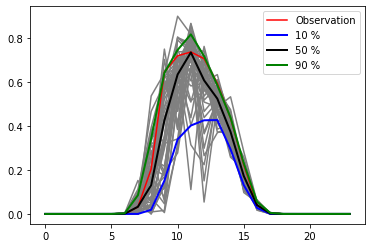

<Figure size 432x288 with 0 Axes>

In [89]:
start = point*24
end = point*24 + 24
# plt.ylim(y_lo, y_hi)

n_s = 100
N_q = 99

# Quantiles are generated into an array of shape (n_day*24, N_q)
q_set = [i / (N_q + 1) for i in range(1, N_q + 1)]
quantiles = np.quantile(pv_nf, q=q_set, axis=1).transpose()

plt.plot(pv_nf[start:end,0:50], color = 'gray')
plt.plot(gt[point], color = 'red', label='Observation')
plt.plot(quantiles[point * 24:(point+1)*24, 9], color='b', linewidth=2, label='10 %')
plt.plot(quantiles[point * 24:(point+1)*24, 49], color='k', linewidth=2, label='50 %')
plt.plot(quantiles[point * 24:(point+1)*24, 89], color='g', linewidth=2, label='90 %')
plt.legend()
plt.show()
plt.clf()

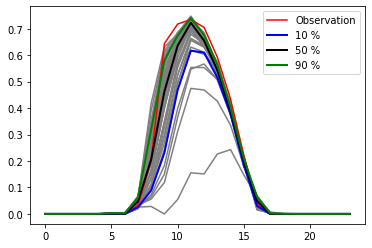

<Figure size 432x288 with 0 Axes>

In [90]:
start = point*24
end = point*24 + 24
# plt.ylim(y_lo, y_hi)

n_s = 100
N_q = 99

# Quantiles are generated into an array of shape (n_day*24, N_q)
q_set = [i / (N_q + 1) for i in range(1, N_q + 1)]
quantiles = np.quantile(pv_vae, q=q_set, axis=1).transpose()

plt.plot(pv_vae[start:end,0:50], color = 'gray')
plt.plot(gt[point], color = 'red', label='Observation')
plt.plot(quantiles[point * 24:(point+1)*24, 9], color='b', linewidth=2, label='10 %')
plt.plot(quantiles[point * 24:(point+1)*24, 49], color='k', linewidth=2, label='50 %')
plt.plot(quantiles[point * 24:(point+1)*24, 89], color='g', linewidth=2, label='90 %')
plt.legend()
plt.show()
plt.clf()

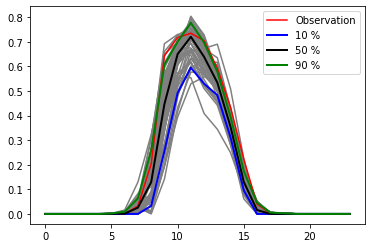

<Figure size 432x288 with 0 Axes>

In [91]:
start = point*24
end = point*24 + 24
# plt.ylim(y_lo, y_hi)

n_s = 100
N_q = 99

# Quantiles are generated into an array of shape (n_day*24, N_q)
q_set = [i / (N_q + 1) for i in range(1, N_q + 1)]
quantiles = np.quantile(pv_gan, q=q_set, axis=1).transpose()

plt.plot(pv_gan[start:end,0:50], color = 'gray')
plt.plot(gt[point], color = 'red', label='Observation')
plt.plot(quantiles[point * 24:(point+1)*24, 9], color='b', linewidth=2, label='10 %')
plt.plot(quantiles[point * 24:(point+1)*24, 49], color='k', linewidth=2, label='50 %')
plt.plot(quantiles[point * 24:(point+1)*24, 89], color='g', linewidth=2, label='90 %')
plt.legend()
plt.show()
plt.clf()

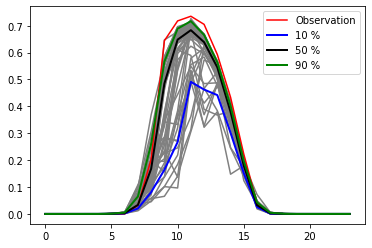

<Figure size 432x288 with 0 Axes>

In [92]:
pv_diff = pv_diff.reshape(-1,100)
start = point*24
end = point*24 + 24
# plt.ylim(y_lo, y_hi)

n_s = 100
N_q = 99

# Quantiles are generated into an array of shape (n_day*24, N_q)
q_set = [i / (N_q + 1) for i in range(1, N_q + 1)]
quantiles = np.quantile(pv_diff, q=q_set, axis=1).transpose()

plt.plot(pv_diff[start:end,0:50], color = 'gray')
plt.plot(gt[point], color = 'red', label='Observation')
plt.plot(quantiles[point * 24:(point+1)*24, 9], color='b', linewidth=2, label='10 %')
plt.plot(quantiles[point * 24:(point+1)*24, 49], color='k', linewidth=2, label='50 %')
plt.plot(quantiles[point * 24:(point+1)*24, 89], color='g', linewidth=2, label='90 %')
plt.legend()
plt.show()
plt.clf()

###########
(3600, 100)
(150, 24)


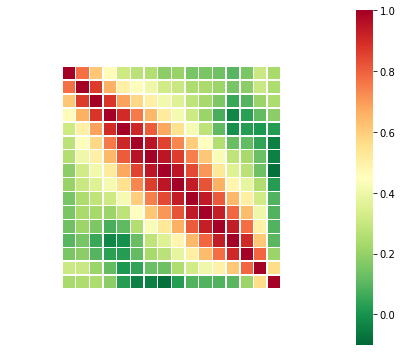

In [98]:
correlations, auto_corr = correlationScenarios(pv_vae, gt)
plt.figure(figsize=(6, 5))
sns_plot = sns.heatmap(auto_corr, cmap='RdYlGn_r', fmt=".1f", linewidths=0.5, xticklabels=False, yticklabels=False,
                        annot=False, vmin=-.1, vmax=1)
sns_plot.set_yticklabels(sns_plot.get_yticklabels(), rotation='horizontal')
plt.tight_layout()
plt.show()